# Как устроен градиентный бустинг и где там градиент?

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np

Привет! Внезапно всем стало интересно, где же градиент в градиентном бустинге. Предлагаю разобраться на практике. Создадим датасет для экспериментов — параболу с шумом.

In [2]:
rnd.seed(42)
m = 1000
X = rnd.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + rnd.randn(m, 1) / 3.1

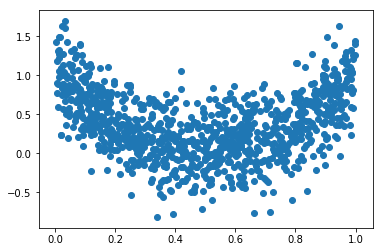

In [3]:
plt.scatter(X,y)

Разобьем датасет на train и test.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Градиентный бустинг — это ансамбль деревьев, значит начнем с одного дерева. Возьмем склёрновское дерево глубиной 1 и предскажем параболу, измерив ошибки на тренировочной и тестовой выборке.

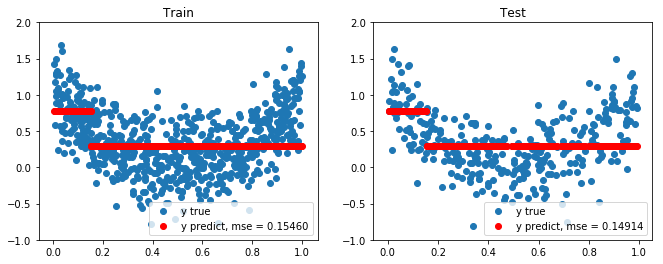

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

tree_reg = DecisionTreeRegressor(max_depth=1,random_state=42)

tree_reg.fit(X_train,y_train)

predict_train = tree_reg.predict(X_train)
predict_test = tree_reg.predict(X_test)

mse_train = mean_squared_error(y_train, predict_train)
mse_test = mean_squared_error(y_test, predict_test)

def plot_train_test():
    plt.figure(figsize=(11, 4))

    plt.subplot(121)
    plt.scatter(X_train,y_train,label='y true')
    plt.scatter(X_train, predict_train, color='r',
                label='y predict, mse = {0:.5f}'.format(mse_train))
    plt.ylim(-1,2)
    plt.title('Train')
    plt.legend(loc='lower right')

    plt.subplot(122)
    plt.scatter(X_test,y_test,label='y true')
    plt.scatter(X_test, predict_test, color='r',
               label='y predict, mse = {0:.5f}'.format(mse_test))
    plt.ylim(-1,2)
    plt.title('Test')
    plt.legend(loc='lower right')
    
plot_train_test()

Слабовато получилось. Вся надежда на градиентный бустинг. Ансамбль градиентного бустинга — группа слабых моделей (у нас как раз такая уже есть), которые вместе образуют сильную модель.

Алгоритм обучения градиентного бустинга.

1. Предсказываем всем точкам константное значение, например 0.
1. Считаем ошибку предсказания: вычитаем предсказанные значения из настоящих и берем с отрицательным знаком.
1. Берем следующее дерево и обучаем его на ошибке из предыдущего шага. 
1. Умножаем предсказание дерева на коэффициент обучения и вычитаем из первого константного предсказания (обновляем его).
1. Повторяем шаги 2-4 для каждого дерева в ансамбле, продолжая обновлять первое предсказание на каждом шаге
Алгоритм предсказания:

Вычитаем из изначального предсказания предсказания каждого дерева, умножая предсказания на коэффициент обучения.

Реализуем алгоритм и обучимся на параболе.

In [6]:
n_estimators = 100 # кол-во деревьев в ансамбле
learning_rate = 0.1 # коэффициент обучения

Создаем список со всеми деревьями, которые будем обучать.

In [7]:
trees = []
for _ in range(n_estimators):
    trees.append(DecisionTreeRegressor(random_state=42, 
                                       max_depth=1))

Делаем первое константное предсказание — все y равны 0.

In [8]:
intial_pred = np.full(np.shape(y_train), 0.) # 1. Предсказываем всем точкам константное значение 0.

Обучение

In [9]:
y_pred = intial_pred.copy() # скопируем первое предсказание

for i in range(n_estimators):
    gradient = -(y_train - y_pred) # 2. Считаем ошибку предсказания: вычитаем 
                                # предсказанные значения из настоящих 
                                # и берем с отрицательным знаком.
        
    trees[i].fit(X_train, gradient) # 3. Берем дерево и обучаем его 
                                    # на ошибке из предыдущего шага
        
    update = trees[i].predict(X_train) # получаем предсказание
    
    y_pred -= learning_rate * update.reshape(-1,1) # 4. Умножаем предсказание 
                        # дерева на коэффициент обучения и обновляем первое
                        # константное значение

Предсказание.

In [10]:
y_pred = np.full(np.shape(y_train), 0.)
for tree in trees:
    update = tree.predict(X_train)
    y_pred -= learning_rate * update.reshape(-1,1)
    
predict_train = y_pred.copy()

Предcказание для тестовой выборки.

In [11]:
y_pred = np.full(np.shape(y_test), 0.)
for tree in trees:
    update = tree.predict(X_test)
    y_pred -= learning_rate * update.reshape(-1,1)
    
predict_test = y_pred.copy()

In [12]:
mse_train = mean_squared_error(y_train, predict_train)
mse_test = mean_squared_error(y_test, predict_test)

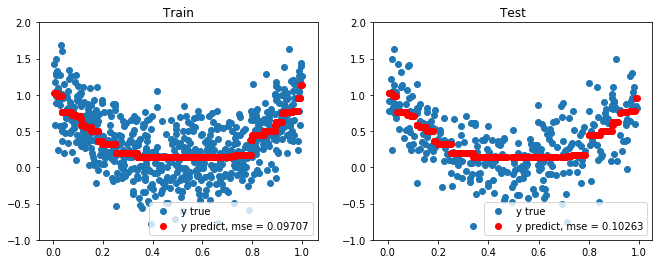

In [13]:
plot_train_test()

Но где же в градиентном бустинге сам градиент? Судя по названиям переменных в коде градиент — ошибка предсказания, т.е. y_true-y_pred. Да, это он. Но почему? В случае бустинга для регрессии, алгоритм минимизирует квадратичную функцию потерь, т.е. (y_true-y_pred)^2. Чтобы что-то минимизировать с помощью градиента, нужно найти производную. Производная по y_pred от (y_true$−$y_pred)^2 будет равна -2*(y_true-y_pred). Двойка на оптимизацию не влияет, поэтому ее можно убрать и получить (y_true-y_pred).

Выводы:
- в градиентном бустинге простые деревья обучаются последовательно
- каждое дерево учится на ошибке предсказания (y_true-y_pred) на каждом шаге
- финальное предсказание на каждом шаге обновляется с помощью ответа очередного дерева
- ошибка предсказания (y_true-y_pred) является градиентом квадратичной функции потерь (y_true-y_pred)^2

Что еще нужно знать:
- градиентный бустинг можно осуществлять над любыми моделями, не только деревьями
- градиетный бустинг в отличии от случайного леса начинает переобучаться с увеличением количества деревьев